# Q Transform with Amplitude Modulation - Example Usage

We download a series of packages needed to download a gravitational wave and process it.

In [1]:
from gwosc.datasets import event_gps
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

import sys
import importlib

import matplotlib.pyplot as plt
import torch

from gwpy.timeseries import TimeSeries

from torchaudio import *
import pandas as pd

Work with GPU if possible

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

We download a ten-seconds time series containing a the GW event GW150914-v3.

In [3]:
event='GW150914-v3'
event_label='GW150914'
gps=event_gps(event)
dets=['L1','H1']
dets_label=['LIGO Livingston (L1)','LIGO Hanford (H1)']
ncols=len(dets)
nrows=3

denoising_threshold=7.
energy_density_threshold=7.

In [4]:
f_s=2048
frange=[20., 500.]
filmethod='highpass_threshold_filtering' 

In [5]:
detector=dets[1] # select the Hanford observatory

delta=.375 #the size of delta determines the total lengh of the time interval, which will be 2*delta
segment=(gps-5, gps+5) #choose an interval centred at the detection time
data_init = TimeSeries.fetch_open_data(detector, *segment, verbose=True) # download data
tensor_data=torch.tensor(data_init) #convert data to PyTorch tensor

Fetched 1 URLs from gwosc.org for [1126259457 .. 1126259468))
Reading data... [Done]


In [6]:
original_sample_rate=int(len(data_init)/(segment[1]-segment[0]))
transform = transforms.Resample(original_sample_rate, f_s, dtype=torch.float64)

data=transform(tensor_data).to(device) #resample the data to f_s
times=np.arange(segment[0], segment[-1], 1./f_s)
original_duration=data.shape[0]/f_s

For the un-whitened data a lower frequency dominates and hides the gravitational wave.

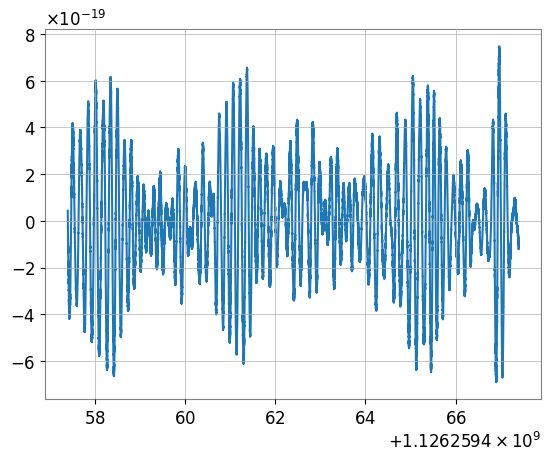

In [7]:
plt.plot(times, data.detach().cpu())

From the Annalisa package we download the STFTWhiten class which we use to whiten the data.

In [8]:
#sys.path.insert(1, '../' )
#importlib.reload(sys.modules['Annalisa_gpu_2_1_0'])
from Annalisa_gpu_2_1_0 import *
importlib.reload(sys.modules['Annalisa_gpu_2_1_0'])

NVIDIA GH200 480GB
Running on device: device='cuda'
NVIDIA GH200 480GB
Running on device: device='cuda'


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'Annalisa_gpu_2_1_0' from '/workspace/notebooks_intertwin/Francesco/Annalisa_gpu_2_1_0.py'>

In [9]:
try:
    del whitener
    torch.cuda.empty_cache()
except:
    pass

whitener = STFTWhiten(
    duration=original_duration,
    psd_nfft=8192, 
    psd_win_length=8192, 
    psd_hop_length=128,
    # Parameters for whitening STFT:
    stft_nfft=8192,
    stft_win_length=8192,
    stft_hop_length=512,  #1024
    stft_window_type='hann', 
    sample_rate=f_s,
    center=True, 
    normalized='energy',
    average_type='median',   # Options: None, 'mean', 'median', 'moving_mean', 'moving_median'
    normalization='ml4gw',   # Options: 'ml4gw', 'nperseg', 'window_sum', 'fftlength', None
    moving_avg_window_ratio=0.2,  
    epsilon=1.0e-31,#1.0e-21,#1.0e-12,              
    # Border mitigation options:
    exclude_border=False,       # Exclude border frames in PSD estimation.
    border_fraction=1/3,       # Fraction of frames to exclude at each end.
    border_mitigation=True,    
    pad_mode="constant",
    # Synthesis window compensation option:
    design_synth_window=True,
    # New window options for PSD and STFT:
    psd_window_type='hann',
    psd_planck_epsilon=0.5,
    psd_kaiser_beta=100,
    truncation_window_type='hann',
    truncation_planck_epsilon=0.5,
    truncation_kaiser_beta=4,
    detrend=True,
#    truncation_window_size=0.04,
    convolve_method='overlapsave'  #'overlapsave' 'stft'
).to(device)

In [10]:
GW_whitened=whitener(data.unsqueeze(0).unsqueeze(0))
#                     , psd_tensor.double().unsqueeze(0).unsqueeze(0))

x.shape=torch.Size([1, 1, 20480])
x.shape=torch.Size([1, 1, 34132])
pad=2048
pad=2048


We then crop an interval of 0.2 seconds around the recorded GPS time of the wave. We plot the Time Series of the wave.

In [11]:
start_time=.15
end_time=.05
GW_whitened=GW_whitened[0][0][int(len(GW_whitened[0][0])/2)-int(start_time*f_s):int(len(GW_whitened[0][0])/2)+int(end_time*f_s)]
times=np.arange(gps-start_time, gps+end_time, 1./f_s)
times=times[:-1]
duration=GW_whitened.shape[0]/f_s

After the whitening, the gravitational wave is more visible.

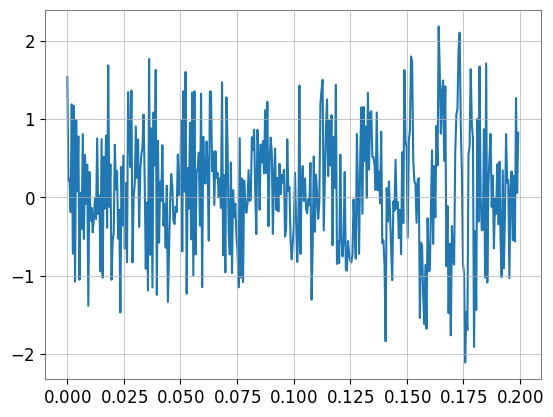

In [12]:
times=np.arange(0., duration, 1./f_s)
plt.plot(times,np.array(GW_whitened.detach().cpu()))

In [ ]:
#from qtransform_gpu_2_0_0 import *

In [13]:
duration=GW_whitened.shape[-1]/f_s

In [14]:
Q=12.
f_range=[8,500]
qtransform_single_Q=SingleQTransform(
                duration=duration,
                sample_rate=f_s,
                spectrogram_shape=[100,100],
                q=Q,
                frange=f_range,
                mismatch=0.2,
                energy_mode=True,
                phase_mode=True
            )

In [15]:
transformed=qtransform_single_Q(GW_whitened)

qt_energy=transformed[0][0][0]
qt_phase=transformed[0][0][1]

We define a function which is useful for plotting the spectrograms.

In [16]:
def set_frequency_ticks(ax, f_range, desired_ticks, log_base, new_height):
    """Sets the y-axis (frequency) ticks and labels."""
    log_f_range = (np.log(f_range[0]) / np.log(log_base), np.log(f_range[1]) / np.log(log_base))
    log_desired_ticks = np.log(desired_ticks) / np.log(log_base)

    y_ticks_pixel = np.interp(log_desired_ticks, log_f_range, [new_height - 1, 0])

    y_ticks_pixel = [int(p) for p in y_ticks_pixel]
    y_ticks_pixel = np.clip(y_ticks_pixel, 0, new_height - 1)

    y_ticks_pixel, unique_indices = np.unique(y_ticks_pixel, return_index=True)
    desired_ticks_used = np.array(desired_ticks)[unique_indices].tolist()

    ax.grid(True, axis='y', which='both')
    ax.set_yticks(y_ticks_pixel)
    ax.set_yticklabels(desired_ticks_used)

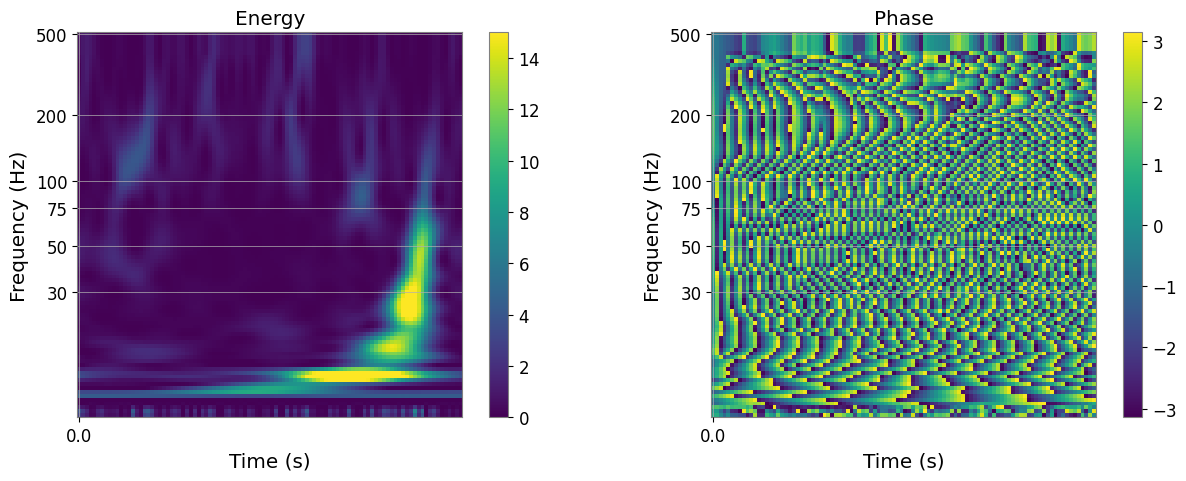

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import math

# --- New Duration ---
length_in_s = duration

# --- Adapted Time Ticks (0.0s, 0.2s, 0.4s, 0.6s) ---
# We use floating-point numbers for the ticks
time_ticks = np.arange(0, duration, 1)

# --- NOTE: The following variables are assumed to be defined by your external code:
# qt_energy, qt_phase (the spectrogram matrices)
# f_range (frequency range for set_frequency_ticks)
# set_frequency_ticks (your custom function for the y-axis)
# ---

desired_ticks = [30, 50, 75, 100, 200, 500]
log_base = 10

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# --- Energy Plot (axes[0]) ---
im0 = axes[0].imshow(np.flipud(qt_energy), vmin=0, vmax=15)
set_frequency_ticks(axes[0], f_range, desired_ticks, log_base, qt_energy.shape[0])

# Calculate X-tick positions in terms of array index
x_tick_pos_energy = [t * qt_energy.shape[1] / length_in_s for t in time_ticks]
axes[0].set_xticks(x_tick_pos_energy)
axes[0].set_xticklabels(time_ticks)

# --- Phase Plot (axes[1]) ---
im1 = axes[1].imshow(np.flipud(qt_phase))
#, vmin=-math.pi, vmax=+math.pi)
set_frequency_ticks(axes[1], f_range, desired_ticks, log_base, qt_phase.shape[0])

# Calculate X-tick positions in terms of array index
x_tick_pos_phase = [t * qt_phase.shape[1] / length_in_s for t in time_ticks]
axes[1].set_xticks(x_tick_pos_phase)
axes[1].set_xticklabels(time_ticks)


# --- Colorbars and Titles (Unchanged) ---
plt.colorbar(im0, ax=axes[0])
plt.colorbar(im1, ax=axes[1])

axes[0].set_title('Energy')
axes[1].set_title('Phase')

# Set X-axis labels to indicate the time dimension
axes[0].set_xlabel('Time (s)')
axes[1].set_xlabel('Time (s)')

# Set Y-axis labels to indicate the frequency dimension
axes[0].set_ylabel('Frequency (Hz)')
axes[1].set_ylabel('Frequency (Hz)')

plt.show()

We have the option of computing directly the QTiles, without any interpolation, neither in time nor in frequency space.
The result will be a series of Qtiles in the form pf PyTorch tensors stacked on top of each other, forming a 2D tensor.
The numerb of QTiles will be the same as the selected central frequencies, and each of them will have length of sample_rate/2+1 .

In [18]:
Q=12
f_range=[8,500]

In [19]:
qtiles_single_Q=SingleQTransform(
                duration=duration,
                sample_rate=f_s,
                spectrogram_shape=None,
                q=Q,
                frange=f_range,
                mismatch=0.2,
                energy_mode=True,
                phase_mode=True,
                qtiles_mode=True,
                unroll_phase=False
            )

In [20]:
qtiles=qtiles_single_Q(GW_whitened)

qtiles_energy=qtiles[0][0][0]
qtiles_phase=qtiles[0][0][1]

Plot both the energy and phase QTiles.

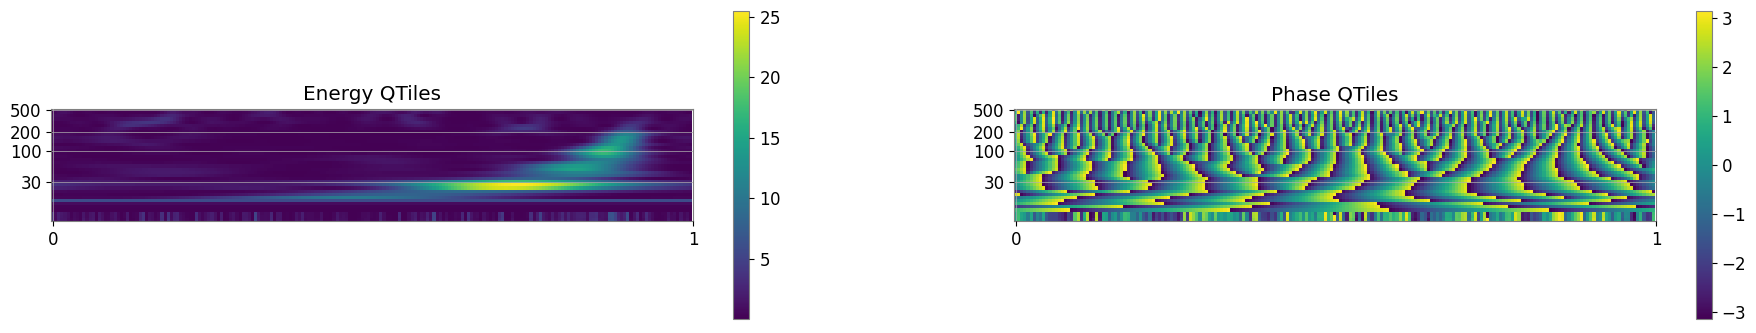

In [21]:
desired_ticks = [30, 100, 200, 500]
log_base=10
length_in_s=1


# Calculate aspect ratio
height, width = qtiles_energy.shape
aspect_ratio = width / height

# Set height and calculate width
fig_height = 4  # readable height
fig_width = fig_height * aspect_ratio

fig, axes= plt.subplots(1, 2, figsize=(fig_width,fig_height))
im0=axes[0].imshow(np.flipud(qtiles_energy))
#, vmin=0, vmax=5*10**(-4))
set_frequency_ticks(axes[0], f_range, desired_ticks, log_base, qtiles_energy.shape[0])

axes[0].set_xticks([k* qtiles_energy.shape[1]//length_in_s for k in range(length_in_s+1)])
axes[0].set_xticklabels([k for k in range(length_in_s+1)])

im1=axes[1].imshow(np.flipud(qtiles_phase))
#, vmin=-math.pi, vmax=+math.pi)
set_frequency_ticks(axes[1], f_range, desired_ticks, log_base, qtiles_phase.shape[0])

axes[1].set_xticks([k* qtiles_phase.shape[1]//length_in_s for k in range(length_in_s+1)])
axes[1].set_xticklabels([k for k in range(length_in_s+1)])

plt.colorbar(im0,ax=axes[0])
plt.colorbar(im1,ax=axes[1])

axes[0].set_title('Energy QTiles')
axes[1].set_title('Phase QTiles')
plt.show()

## Study of Different Window Functions to Compute the QTAM

Each Q-Tile **X** with central frequency **f** is computed as $$X_f(\tau, Q)= \int_{-\infty}^{+\infty} x(t)w_f(t-\tau, Q)e^{-2\pi i Q t} dt .$$  
In this section we show the results for different choices of windows: Kaiser window, Hann window, Tukey window and Planck-Taper window. 
We compute and plot each of these windows with diffrent choices of parameters.

The Kaiser window is defined as $$ K_{i}= I_{0} \left( \beta \sqrt ( 1- ( \frac{1-N/2}{N/2} )^{2} ) \right) /I(\beta) .$$ 
With $$I_{0}(x) =\sum_{k=0}^{\infty} \frac{(x^2/4)^{k}}{(k!)^2} $$ being the zeroth Bessel function.

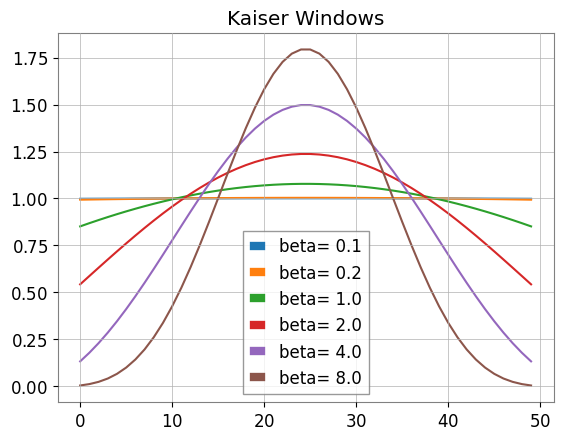

In [22]:
for beta in [0.1, 0.2, 1.0, 2.0, 4.0, 8.0]:
    w=torch.kaiser_window(50, beta=beta, periodic=False, device='cpu', dtype=torch.float64)
    w = w / torch.sqrt(torch.mean(w**2)).item()
    plt.plot(w, label='beta= '+str(beta))
    plt.title('Kaiser Windows')
    plt.legend()

The Hann window is defined as $$ w[n]= \sin^{2} \left( \frac{\pi n}{N-1} \right) $$, where N is the full window size.

Text(0.5, 1.0, 'Hann Window')

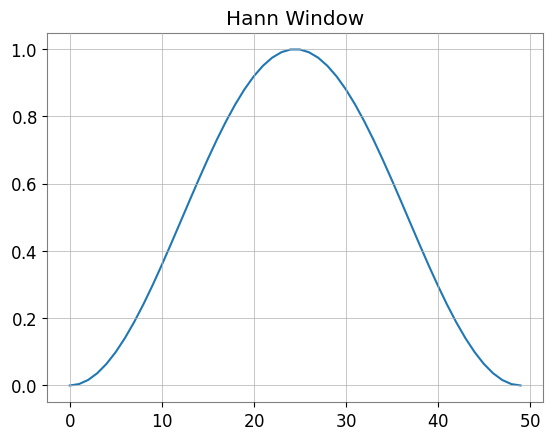

In [23]:
hann_window = torch.hann_window(50, periodic=False, device='cpu', dtype=torch.float64)
plt.plot(hann_window)
plt.title('Hann Window')

The Tukey window, also known as *cosine tapered window* has expression

\begin{cases}
 w[n] = \frac{1}{2} \left[ 1 - \cos \left(  \frac{2 \pi n}{\alpha N}  \right) \right] & \text{for } 0 \leq n \leq \frac{\alpha N}{2}, \\
w[n] = 1 & \text{for } \frac{\alpha N}{2} < n < \frac{N}{2}, \\
w[N-n]=w[n] & \text{for } 0 \leq n \leq \frac{N}{2}. 
\end{cases}

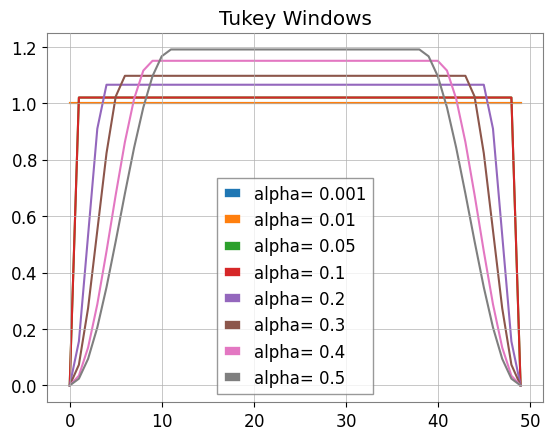

In [24]:
for alpha in [0.001,0.01,0.05,0.1,0.2,0.3,0.4,0.5]:
    window=tukey_window_range(50, alpha=alpha, norm=True)
    plt.plot(window, label='alpha= '+str(alpha))
    plt.title('Tukey Windows')
    plt.legend()

The Planck-Taper window is defines as
\begin{cases}
w[n] = \left( 1+ \exp( \frac{\epsilon N }{n}- \frac{\epsilon N}{\epsilon N - n} \right)^{-1} & \text{for } 1 \leq n \leq \epsilon N, \\
w[n] = 1 & \text{for } \epsilon N< n < \frac{N}{2}, \\
w[N-n]=w[n] & \text{for } 0 \leq n \leq \frac{N}{2} .
\end{cases}

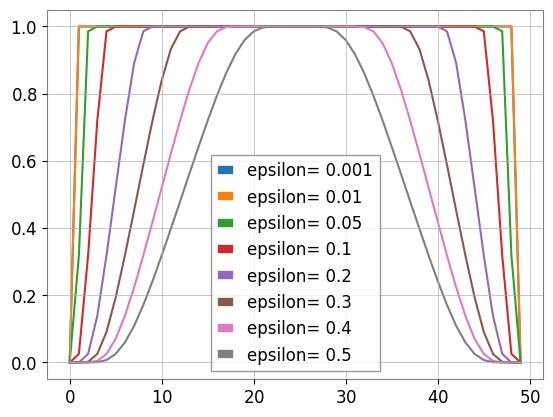

In [25]:
for epsilon in [0.001,0.01,0.05,0.1,0.2,0.3,0.4,0.5]:
    window=planck_taper_window_range(50, epsilon=epsilon, norm=True, device='cpu')
    plt.plot(window, label='epsilon= '+str(epsilon))
    plt.legend()

We now compute the QTs with different windows and for each window we span a range of parameters.

In [26]:
import time
import torch
import numpy as np
# Assuming SingleQTransform, duration, f_s, q, frange, data_torch, and device are defined

# --- New Configuration for num_freq ---
num_freq_values = [32, 64, 128, 256]
# --------------------------------------

# Define parameter ranges
tau_range_tukey = [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
tau_range_planck = [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
beta_range_kaiser = [0.1, 0.2, 0.5, 1.0, 2.0, 4.0, 8.0]

# Structure the base configurations (independent of num_freq)
base_configs = []

# Non-parameter windows
base_configs.append({'window_type': None, 'tau': None, 'beta': None})
base_configs.append({'window_type': 'hann', 'tau': None, 'beta': None})

# Tukey window
for tau in tau_range_tukey:
    base_configs.append({'window_type': 'tukey', 'tau': tau, 'beta': None})

# Planck-taper window (using tau for epsilon)
for tau in tau_range_planck:
    base_configs.append({'window_type': 'planck-taper', 'tau': tau, 'beta': None})

# Kaiser window
for beta in beta_range_kaiser:
    base_configs.append({'window_type': 'kaiser', 'tau': None, 'beta': beta})

# The qtransforms list will now be a list of lists,
# where each inner list holds the 4 results for the same window config.
qtransforms_grouped = []
# We also need a simplified list of names/configs for plotting the row headers
row_configs = []

total_runs = len(base_configs) * len(num_freq_values)
print(f"Testing {total_runs} total window configurations...")

for config in base_configs:
    window_type = config['window_type']
    tau = config['tau']
    beta = config['beta']

    # Determine the configuration name for print/plotting (the row header)
    if window_type == 'tukey':
        name = f"Tukey ($\\tau={tau}$)"
    elif window_type == 'planck-taper':
        name = f"Planck-taper ($\\epsilon={tau}$)"
    elif window_type == 'kaiser':
        name = f"Kaiser ($\\beta={beta}$)"
    elif window_type is None:
        name = "Rectangular (None)"
    else:
        name = str(window_type).capitalize()

    row_configs.append(name)
    current_config_results = []

    for num_freq in num_freq_values:
        # NOTE: Update spectrogram_shape based on num_freq, assuming fixed time axis (384)
        spectrogram_shape = [num_freq, 384]

        # Initialize the QTransform
        qtransform = SingleQTransform(
            duration=duration,
            sample_rate=f_s,
            q=Q,
            spectrogram_shape=spectrogram_shape, # Updated
            qtiles_mode=True,
            energy_mode=True,
            phase_mode=True,
            frange=frange,
            logf=True,
            num_freq=num_freq, # Updated
            window_param=window_type,
            tau=tau,
            beta=beta
        ).to(device)

        start = time.time()
        # The output tensor shape will now depend on num_freq
        energy = qtransform(GW_whitened)
        #, norm=True)
        
        # Store the energy tensor directly, as it has a different shape
        current_config_results.append(energy[0, 0, 0].cpu().numpy())
        
        del energy
        torch.cuda.empty_cache()
        print(f'{name} (num_freq={num_freq}) took: {time.time() - start:.3f}s')

    qtransforms_grouped.append(current_config_results)
# qtransforms_grouped is a list of lists: [[nf32, nf64, nf128, nf256], [nf32, nf64, ...], ...]

Testing 100 total window configurations...
Rectangular (None) (num_freq=32) took: 0.023s
Rectangular (None) (num_freq=64) took: 0.010s
Rectangular (None) (num_freq=128) took: 0.020s
Rectangular (None) (num_freq=256) took: 0.039s
Hann (num_freq=32) took: 0.005s
Hann (num_freq=64) took: 0.009s
Hann (num_freq=128) took: 0.019s
Hann (num_freq=256) took: 0.039s
Tukey ($\tau=0.001$) (num_freq=32) took: 0.005s
Tukey ($\tau=0.001$) (num_freq=64) took: 0.009s
Tukey ($\tau=0.001$) (num_freq=128) took: 0.018s
Tukey ($\tau=0.001$) (num_freq=256) took: 0.040s
Tukey ($\tau=0.01$) (num_freq=32) took: 0.006s
Tukey ($\tau=0.01$) (num_freq=64) took: 0.010s
Tukey ($\tau=0.01$) (num_freq=128) took: 0.019s
Tukey ($\tau=0.01$) (num_freq=256) took: 0.040s
Tukey ($\tau=0.05$) (num_freq=32) took: 0.005s
Tukey ($\tau=0.05$) (num_freq=64) took: 0.010s
Tukey ($\tau=0.05$) (num_freq=128) took: 0.018s
Tukey ($\tau=0.05$) (num_freq=256) took: 0.054s
Tukey ($\tau=0.1$) (num_freq=32) took: 0.007s
Tukey ($\tau=0.1$) (n

Once the QTs are computed in **qtransforms_grouped**, we plot them side by side to show the different effects of the choices.

/tmp/ipykernel_23748/99590546.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 0.98]) # Final layout adjustment - right=0.92 reserved for colorbar, top=0.96 reserved for suptitle


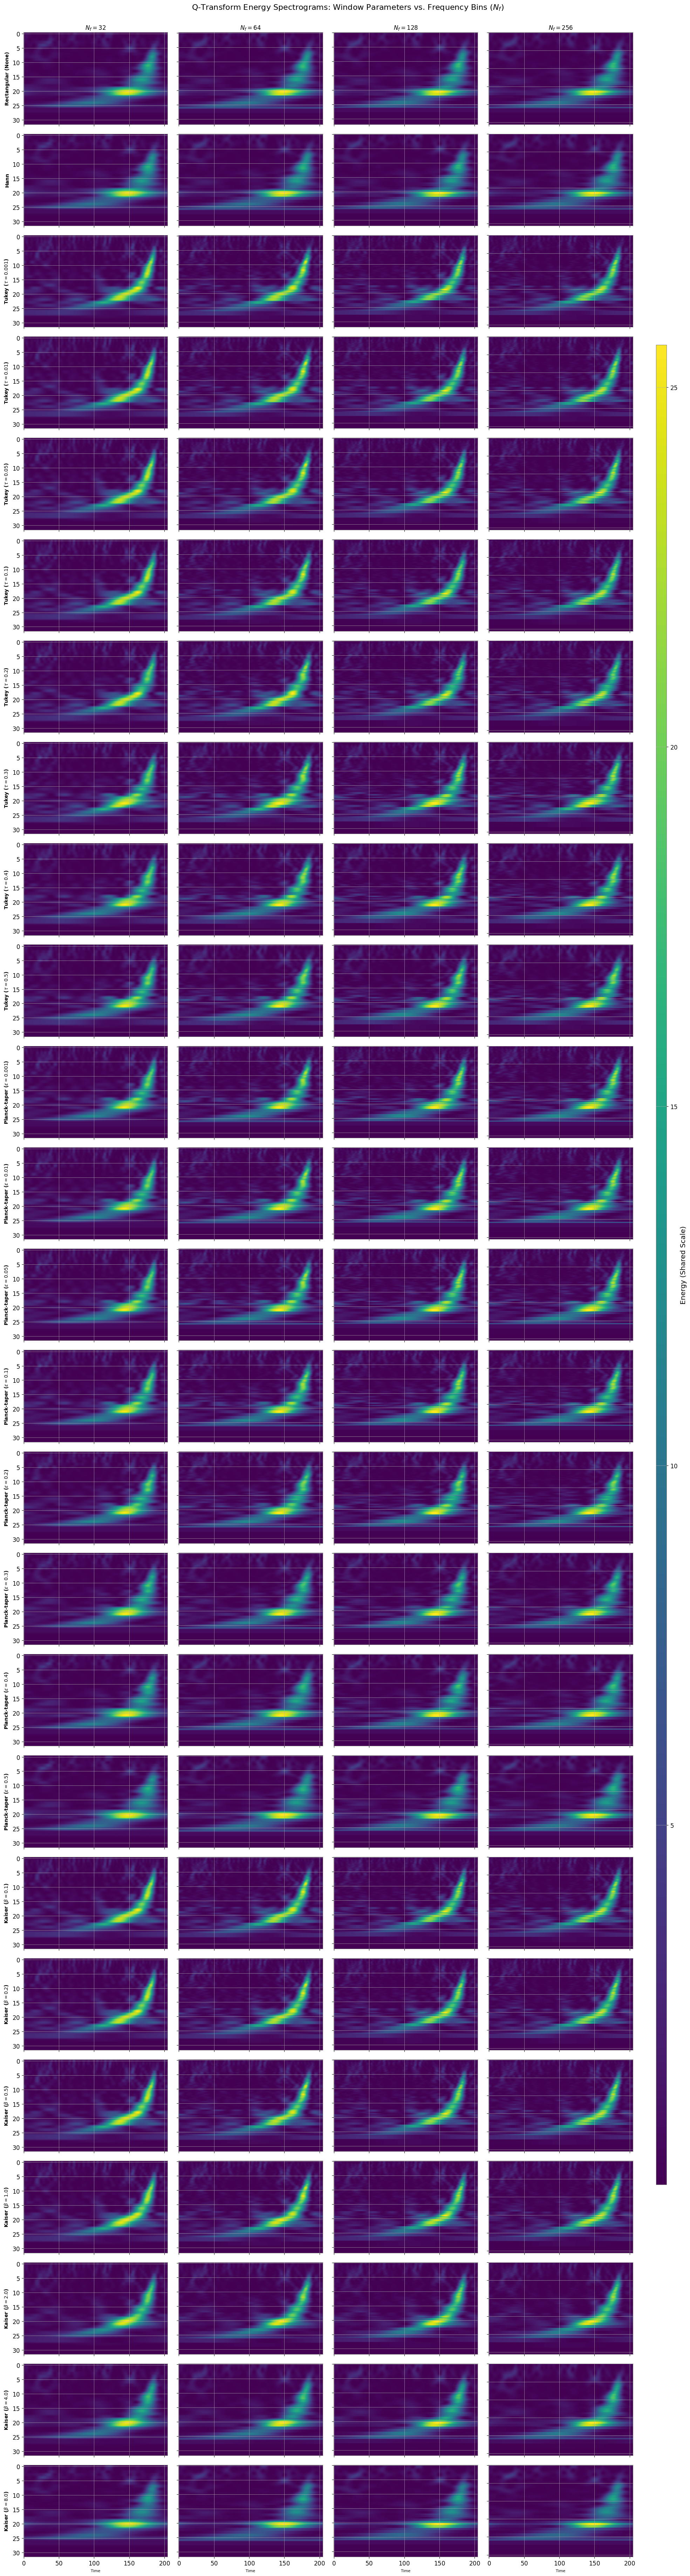

In [27]:
# --- Configuration Parameter ---
num_freq_values = [32, 64, 128, 256] # For column headers
PLOTS_PER_ROW = len(num_freq_values)

# -------------------------------

num_base_configs = len(qtransforms_grouped)
num_cols = PLOTS_PER_ROW
num_rows = num_base_configs # Each base config is now a row

# Define common color scale
vmin = 0
vmax = 25

# Create the figure and axes
# Use a smaller aspect ratio for the figure since we have many rows
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 3 * num_rows), squeeze=False)

# Main Plotting Loop
for row in range(num_rows):
    # Get the results for the current window configuration
    row_results = qtransforms_grouped[row]
    row_name = row_configs[row]

    for col in range(num_cols):
        ax = axes[row, col]
        spectrogram = row_results[col]
        num_freq = num_freq_values[col]

        # Plot the spectrogram
        # The last 'im' object will be used for the colorbar
        im = ax.imshow(np.flipud(spectrogram), aspect='auto')
        #, vmin=vmin, vmax=vmax)

        # Set Row Label (Window Configuration)
        if col == 0:
            ax.set_ylabel(row_name, fontsize=10, weight='bold')
        
        # Set Column Title (num_freq value)
        if row == 0:
            ax.set_title(f"$N_f={num_freq}$", fontsize=12)

        # Set X-axis label only for the bottom row
        if row == num_rows - 1:
            ax.set_xlabel('Time', fontsize=8)
        else:
            # Hide x-axis tick labels for inner rows
            ax.tick_params(axis='x', labelbottom=False)

        # Hide y-axis tick labels for inner columns
        if col > 0:
            ax.tick_params(axis='y', labelleft=False)

# --- Single Colorbar for all plots ---
# Adjust layout to make space for better subplot spacing and the colorbar
fig.subplots_adjust(right=0.92, top=0.9, hspace=0.3, wspace=0.1)
cbar_ax = fig.add_axes([0.94, 0.15, 0.015, 0.7]) # [left, bottom, width, height]

if num_base_configs > 0:
    fig.colorbar(im, cax=cbar_ax, label='Energy (Shared Scale)')
# -------------------------------------

fig.suptitle('Q-Transform Energy Spectrograms: Window Parameters vs. Frequency Bins ($N_f$)', fontsize=16)
#plt.tight_layout(rect=[0, 0, 0.92, 1]) # Final layout adjustment
plt.tight_layout(rect=[0, 0, 0.92, 0.98]) # Final layout adjustment - right=0.92 reserved for colorbar, top=0.96 reserved for suptitle

#plt.savefig('qt_window_test.pdf') # Removed, as you had it commented out
plt.show()